#### 1. Setup And Import ####

In [1]:
pip install labelme tensorflow opencv-python matplotlib albumentations

  Using cached labelme-5.2.0.post4.tar.gz (1.5 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tensorflow-2.12.0-cp311-cp311-win_amd64.whl (1.9 kB)
  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
  Using cached matplotlib-3.7.1-cp311-cp311-win_amd64.whl (7.6 MB)
  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached imgviz-1.7.2-py3-none-any.whl (7.7 MB)
  Using cached natsort-8.3.1-py3-none-any.whl (38 kB)
     -------------------------------------- 14.8/14.8 MB 819.1 kB/s eta 0:00:00
  Using cached Pillow-9.5.0-cp311-cp311-win_amd64.whl (2.5 MB)
     ------------------------------------ 143.2/143.2 kB 772.9 kB/s eta 0:00:00
     ---------------------------------------- 84.9/84.9 kB 1.2 MB/s eta 0:00:00
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
     ---------------------------------------- 6.8/6.8 MB 562.7 kB/s eta 0:00:00
  Using cached tensorflow_inte

  DEPRECATION: wrapt is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  DEPRECATION: labelme is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os
import time
import uuid     # Create unique file names for images
import cv2

##### 2. Collect Images Using Opencv #####

In [35]:
image_path = os.path.join('data','images')
number_images = 30

In [3]:
cap = cv2.VideoCapture(0)
for imgnum in range (number_images):
    print('collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    img_name = os.path.join(image_path, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(0) & 0xff == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


collecting image 0


: 

: 

##### 3. Annotate Images with labelme #####

In [ ]:
# 'labelme' on cmd or !labelme on notebook

##### 4. Build Image Loading Function #####

In [7]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load images to TF pipeline
images = tf.data.Dataset.list_files('data\images\*.jpg', shuffle= False)
images.as_numpy_iterator().next()   # Inspect the elements of dataset

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [4]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
images = images.map(load_image)
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

##### 5. Visualize Raw Images #####

In [7]:
img_generator = images.batch(4).as_numpy_iterator()
plt_imgs = img_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plt_imgs):
    ax[idx].imshow(image)


NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: data\images\c1592b43-f165-11ed-bf35-b05adaf011d5.jpg : The system cannot find the file specified.
; No such file or directory
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

##### 6. Partition Unaugmented Data #####
Manually split data into train test and val

In [34]:
# Move the matching labels
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

##### 7. Apply image augmentations by Albumentations #####

In [6]:
import albumentations as alb

augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

##### 8. Load a test image and annotation with opencv and json #####

In [7]:
img = cv2.imread(os.path.join('data','train', 'images','0bdc2ae8-f0c6-11ed-93a2-b05adaf011d5.jpg'))
with open(os.path.join('data', 'train', 'labels', '0bdc2ae8-f0c6-11ed-93a2-b05adaf011d5.json'), 'r') as f:
    label = json.load(f)
    

label['shapes'][0]['points']

[[168.4771573604061, 62.842639593908636],
 [393.8578680203046, 345.5837563451777]]

In [8]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [9]:
coords = list(np.divide(coords, [640,480,640,480]))

In [10]:
coords

[0.2632455583756345, 0.130922165820643, 0.6154029187817259, 0.7199661590524535]

##### 9. Apply Augmentations and View Results #####

In [11]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [12]:
augmented['bboxes'][0][2:]

(0.6278285391990976, 0.8759052453468696)

In [13]:
augmented['bboxes']

[(0.12698251551043427,
  0.2475916525662718,
  0.6278285391990976,
  0.8759052453468696)]

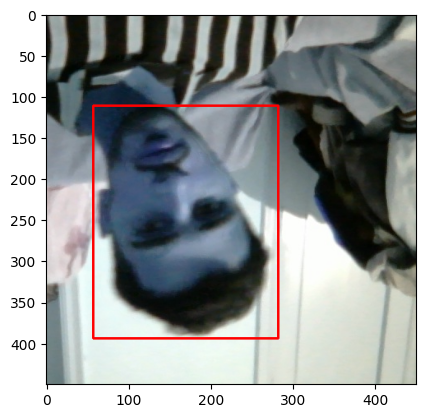

In [14]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

##### 10. Build an Augmentation pipeline #####

In [25]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.7502379441624365, 0.6935279187817259, 0.4686706852791878, 0.15630287648054147, 'face'].
x_max is less than or equal to x_min for bbox [0.8271732233502538, 0.6364213197969543, 0.5257772842639594, 0.08016074450084604, 'face'].
x_max is less than or equal to x_min for bbox [0.19503489847715735, 0.3487732656514383, 0.001506979695431454, 0.8035109983079527, 'face'].
x_max is less than or equal to x_min for bbox [0.20613895939086296, 0.3170473773265652, 0.0, 0.8192584695680302, 'face'].
x_max is less than or equal to x_min for bbox [0.7082011421319796, 0.5867174280879865, 0.29497144670050757, 0.0008460236886632944, 'face'].
x_max is less than or equal to x_min for bbox [0.6621986040609137, 0.6343062605752962, 0.38063134517766495, 0.09073604060913708, 'face'].
y_max is less than or equal to y_min for bbox [0.6986833756345178, 0.7506345177664975, 0.9969067258883249, 0.22186971235194586, 'face'].
x_max is less than or equal to x_min for bbox [0.7

##### 11. Load Augmented Images to tensorflow dataset #####

In [15]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [16]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [17]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

##### 12. Prepare Labels #####

In [18]:
# Label loading function
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return label['class'], label['bbox']

In [19]:
# Load labels to tensorflow dataset
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [20]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [21]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [22]:
train_labels.as_numpy_iterator().next()

(1, array([0.4622, 0.2228, 0.918 , 0.901 ], dtype=float16))

##### 13. Combine Labels and image samples #####

In [23]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3060, 3060, 480, 480, 780, 780)

In [24]:
# Create Final dataset (images/labels)
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [25]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(13000)
test = test.batch(8)
test = test.prefetch(4)

In [26]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [27]:
train.as_numpy_iterator().next()[1]

(array([1, 1, 0, 1, 1, 0, 1, 1], dtype=uint8),
 array([[0.0848 , 0.03662, 0.4932 , 0.6357 ],
        [0.354  , 0.259  , 0.8447 , 0.972  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1907 , 0.1515 , 0.606  , 0.7246 ],
        [0.09534, 0.2498 , 0.602  , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.809  , 0.2312 , 1.     , 0.749  ],
        [0.3252 , 0.     , 0.7856 , 0.63   ]], dtype=float16))

##### 14. View Images And Annotations #####

In [28]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


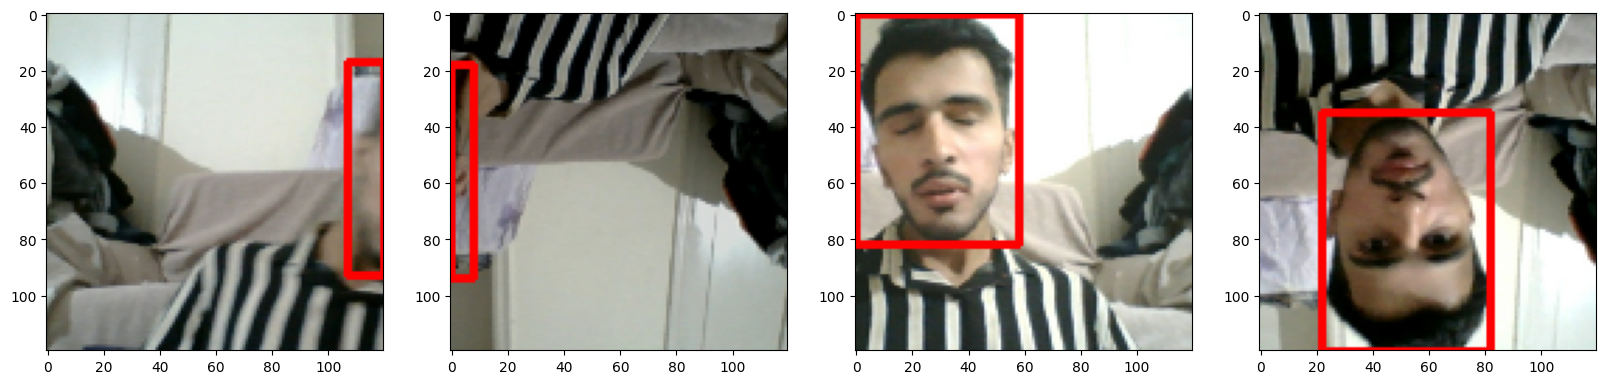

In [29]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

##### 15. Build Deep Learning Model Using Functional API #####

In [33]:
# Import Layer and base network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [34]:
VGG = VGG16(include_top=False)

58889256/58889256 [==============================] - 56s 1us/step


In [35]:
VGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [39]:
# Build our model
def build_model():
    input_layer = Input(shape=(120,120,3))
    VGG = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(VGG)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bouding Box Model
    f2 = GlobalMaxPooling2D()(VGG)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2  =Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [40]:
facetracker = build_model()

In [41]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                                

In [45]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [43]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [46]:
classes, coords

(array([[0.46571624],
        [0.4172053 ],
        [0.45356303],
        [0.42512026],
        [0.43840188],
        [0.4122065 ],
        [0.43216345],
        [0.4233108 ]], dtype=float32),
 array([[0.56229573, 0.44526333, 0.38860098, 0.5082965 ],
        [0.61703855, 0.3548938 , 0.41639122, 0.5256945 ],
        [0.6755856 , 0.35377055, 0.54524857, 0.5469963 ],
        [0.56015265, 0.36996225, 0.5133136 , 0.58576566],
        [0.50777876, 0.4188137 , 0.40483156, 0.5444418 ],
        [0.64147663, 0.3607218 , 0.51379925, 0.54593146],
        [0.5776209 , 0.40074474, 0.46007675, 0.5582738 ],
        [0.63709766, 0.3653227 , 0.5155446 , 0.5665327 ]], dtype=float32))

##### 16. Losses And Optimizers #####

In [47]:
batch_per_epoch = len(train)
lr_decay = (1./.75 - 1)/batch_per_epoch


In [49]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [50]:
# Localization/ regression loss
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [51]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [53]:
# Test Loss Metrics
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.8416777>

In [54]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8032197>

In [55]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.8416777>

##### 17. Train Neural Network #####

In [56]:
# Custom Model Class
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [57]:
model = FaceTracker(facetracker)

In [58]:
model.compile(opt, classloss, regressloss)

##### 18. Train #####

In [59]:

logdir='logs'

In [60]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [61]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
383/383 [==============================] - 943s 2s/step - total_loss: 0.2382 - class_loss: 0.0479 - regress_loss: 0.2142 - val_total_loss: 0.0938 - val_class_loss: 2.8223e-04 - val_regress_loss: 0.0937
Epoch 2/10
383/383 [==============================] - 879s 2s/step - total_loss: 0.0427 - class_loss: 0.0059 - regress_loss: 0.0398 - val_total_loss: 0.0225 - val_class_loss: 1.2726e-05 - val_regress_loss: 0.0225
Epoch 3/10
383/383 [==============================] - 862s 2s/step - total_loss: 0.0263 - class_loss: 0.0038 - regress_loss: 0.0244 - val_total_loss: 0.0279 - val_class_loss: 0.0124 - val_regress_loss: 0.0217
Epoch 4/10
383/383 [==============================] - 849s 2s/step - total_loss: 0.0354 - class_loss: 0.0057 - regress_loss: 0.0325 - val_total_loss: 0.0025 - val_class_loss: 2.3082e-05 - val_regress_loss: 0.0025
Epoch 5/10
383/383 [==============================] - 850s 2s/step - total_loss: 0.0108 - class_loss: 0.0039 - regress_loss: 0.0089 - val_total_loss: 0.

##### 19. Plot Performance #####

In [62]:
hist.history

{'total_loss': [0.014608064666390419,
  0.0019856372382491827,
  0.0024510466028004885,
  0.009634297341108322,
  0.004292485304176807,
  0.00020465465786401182,
  0.0022296998649835587,
  0.012730557471513748,
  0.0007159120286814868,
  0.0010949018178507686],
 'class_loss': [8.294833241961896e-05,
  0.00011148340854560956,
  0.00011746308882720768,
  0.00018752360483631492,
  1.8895378161687404e-05,
  2.0444947949727066e-05,
  1.490116545710407e-07,
  2.7419011530582793e-05,
  1.1876505595864728e-05,
  6.95523340255022e-05],
 'regress_loss': [0.014566590078175068,
  0.0019298954866826534,
  0.0023923150729388,
  0.009540535509586334,
  0.004283037502318621,
  0.000194432184798643,
  0.0022296253591775894,
  0.012716848403215408,
  0.0007099737995304167,
  0.0010601256508380175],
 'val_total_loss': [0.093848817050457,
  0.02250029146671295,
  0.02786114066839218,
  0.0024669275153428316,
  0.005282978527247906,
  0.027844104915857315,
  0.029910963028669357,
  1.408793330192566,
  0.0

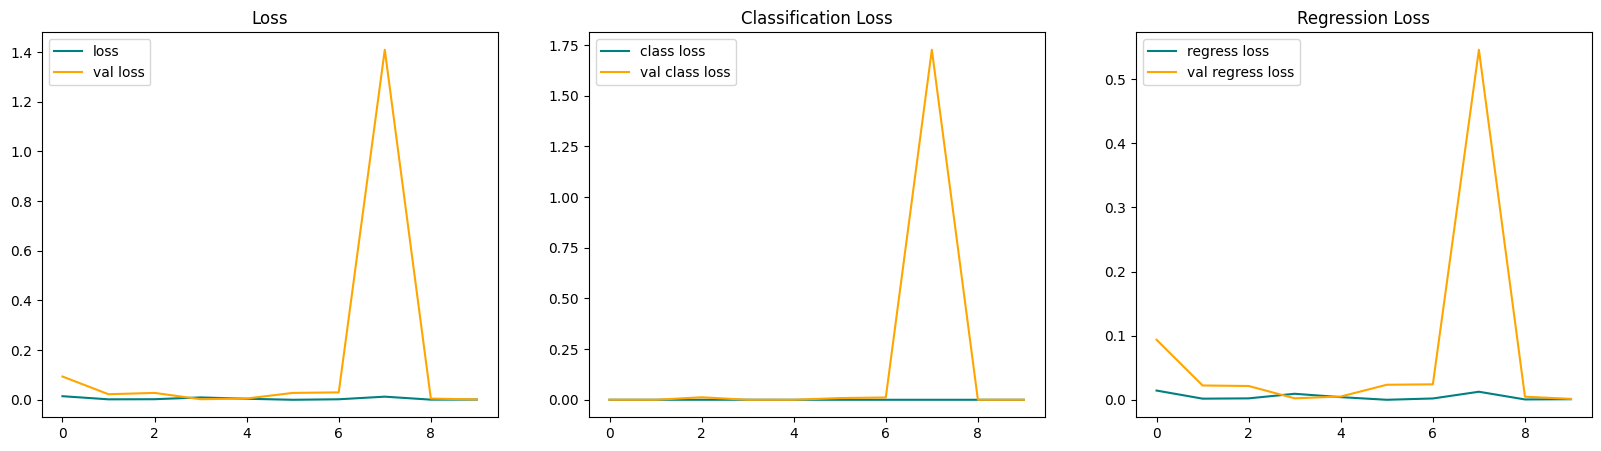

In [63]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

##### 20. Make Predictions #####

In [64]:
test_data = test.as_numpy_iterator()

In [65]:
test_sample = test_data.next()

In [74]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 597ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


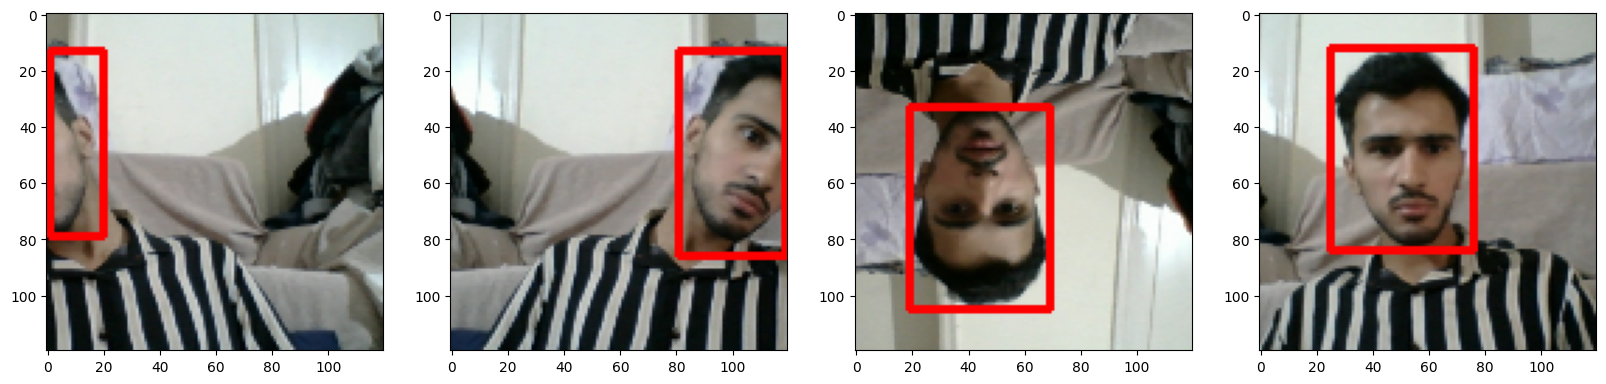

In [67]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

##### 21. Save the Model #####

In [2]:
from tensorflow.keras.models import load_model

In [73]:
facetracker.save('facetracker.h5')

In [3]:
facetracker = load_model('facetracker.h5')

##### 22. Realtime Detection #####

In [8]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 82ms/step


KeyboardInterrupt: 

: 